In [246]:
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *


import warnings
warnings.filterwarnings('ignore')

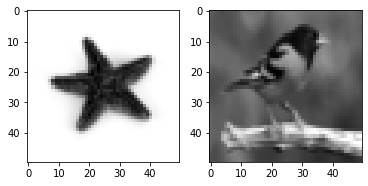

In [247]:
n = 50
A = rescale(load_image("bird.jpg", n))
B = rescale(load_image("starfish.jpg", n))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(B, cmap='gray')
axarr[1].imshow(A, cmap='gray')

f.savefig("Test.png")

# The test images

(40, 20)
()
[5.6375 0.8    1.5625 0.4125 0.2625 0.2    0.1875 0.25   0.275  0.4125]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


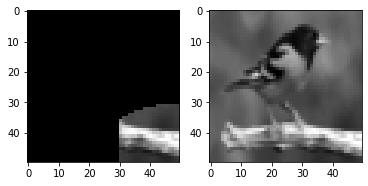

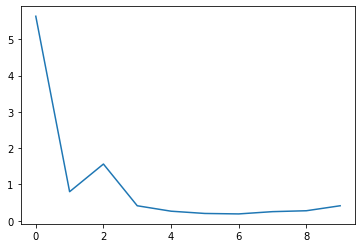

In [248]:
## The helper function
## nt_toolbox is numpy compatible

# the c is 1 
# rho = 2 * sigma

def K(sigma : float, d : np.array ) -> float:
    value = 0.
    rho = 2 * sigma
    d_n = np.linalg.norm(d)
    if(d_n < rho**2):
        value = np.exp(-d_n**2 / (2*sigma))
    return value

# neighborhood of x
def neighborhood(img : np.ndarray, x : np.array, r : float):
    h, w  = img.shape
    #print("The image shape", h, w)

    a1 = min(w, x[0]+r)
    a2 = min(h, x[1]+r)
    a3 = max(0, x[0]-r)
    a4 = max(0, x[1]-r)
        
    Y, X = np.ogrid[a3:a1, a4:a2]
    dist_from_center = np.sqrt((X - x[0])**2 + (Y - x[1])**2)
    mask = dist_from_center <= r
    portion = img.copy()
    p = portion.copy()
    portion = np.zeros((h,w))
    portion[a3:a1, a4:a2] = mask * p[a3:a1, a4:a2] 
    
    return portion[a3:a1, a4:a2], portion
 

f, axarr = plt.subplots(1,2)    

mask, image = neighborhood(A, [50,70], 40)
print(mask.shape)
from matplotlib import pyplot as plt
axarr[0].imshow(image, cmap='gray')
axarr[1].imshow(A, cmap='gray')

f.savefig("Kernel.png")

x = np.array([40., 30.])
print(K(100., x).shape)

# Drawing histogram
hist, bin_edges = np.histogram(mask, density=True)
print(hist)
print(bin_edges)

fig = plt.figure()
plt.plot(hist)
fig.show()


In [249]:
EPSILON = 0.00001

def histogram(image : np.ndarray, x: np.array, r: float, z : float):
    _,neigh = neighborhood(image, x, r)
    h, w = image.shape
    
    count = 0
    #print("neigh",neigh)
    for i in np.asarray(neigh).ravel():
        #print("i",i)
        #print("z", z)
        if(abs(i-z)<EPSILON):
            count += 1
    return count

def cummulative(image : np.ndarray, x: np.array, r : float, z : float):
    neigh, _ = neighborhood(image, x, r)
    h, w = image.shape
    
    count = 0
    for i in np.asarray(neigh).ravel():
        if(i-z<0.):
            count += 1
    return count

In [250]:
LAMBDA = 2
TAU = 0.5

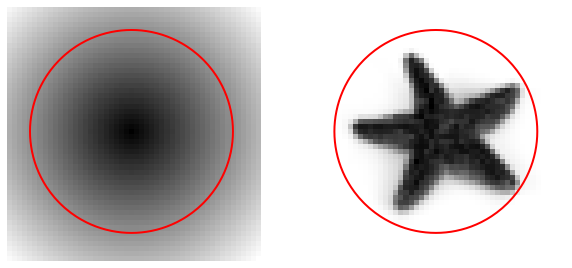

In [260]:
# Initialising the level set funtion

from nt_toolbox.plot_levelset import *

plt.figure(figsize=(10,5))
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
k = 1 #number of circles
r = .4*n/k
phi0 = np.zeros([n,n])+np.float("inf")

for i in range(1,k+1):
    for j in range(1,k+1):
        c = (np.asarray([i,j]) - 1)*(n/k) + (n/k)*.5
        phi0 = np.minimum(phi0,np.sqrt(abs(X-c[0])**2 + abs(Y-c[1])**2) - r)
        
plt.subplot(1,2,1)
plot_levelset(phi0,0)
plt.subplot(1,2,2)
plot_levelset(phi0, 0, B)


plt.savefig("Initial.png")

In [252]:
from nt_toolbox.grad import *
from numpy import linalg
from scipy import integrate


SIGMA = 50.
x = [50, 50]
R = 6

Tmax = 100
niter = int(Tmax/ TAU)
plt.figure(figsize=(10,10))
k = 0

def Converge_contours(img : np.ndarray):
    
    for i in range(1,niter+1):
        print("==========================================")
        print("At iteration ", i)
        print("==========================================")
        #print(i)
        # Converging to the solution
        h,w = img.shape
        phi = np.copy(phi0)
        
        
        #the first term
        gD = grad(phi, order=2)
        gD_norm = linalg.norm(gD)
        gD /= gD_norm
        #print(gD.shape)
        # why nor order 2, see nt box
        ggD = grad(gD, order=1)

        # second term
        
        
        def heaviside(phi_value : float) -> float:
            return int(phi_value > 0.)
        
        #histogram updating functions
        def histogram_i(image : np.ndarray, x : np.array, r : float, z : float):
            
            def f(y1 : int, y2 : int) -> float:
                y1, y2 = int(y1), int(y2)
                y = np.array([y1,y2])
                return heaviside(phi[y1,y2])*K(SIGMA, x-y)*histogram(img, y, R, z)
            
            def g(y1 : int, y2 : int) -> float:
                y1, y2 = int(y1), int(y2)
                y = np.array([y1,y2])
                return heaviside(phi[y1,y2])*K(SIGMA, x-y)
            
            print("Integrating hi")
            a = integrate.nquad(f, [[0, w],[0, h]])[0] 
            b = integrate.nquad(g, [[0, w],[0, h]])[0]
            
            if( b == 0.0):
                value = a / EPSILON
            else:
                value = a / float(b)
            # integrate
            return value
        
        
        def histogram_o(image : np.ndarray, x : np.array, r : float, z : float):
            
            def f(y1 : int, y2 : int) -> float:
                y1, y2 = int(y1), int(y2)
                y = np.array([y1,y2])
                return (1-heaviside(phi[y1,y2]))*K(SIGMA, x-y)*histogram(img, y, R, z)
            
            def g(y1 : int, y2 : int) -> float:
                y1, y2 = int(y1), int(y2)
                y = np.array([y1,y2])
                return (1-heaviside(phi[y1,y2]))*K(SIGMA, x-y)
            
            print("Integrating ho")
            a = integrate.nquad(f, [[0, w],[0, h]])[0] 
            b = integrate.nquad(g, [[0, w],[0, h]])[0]
            
            if( b == 0.0):
                value = a / EPSILON
            else:
                value = a / float(b)
            # integrate
            return value
        

        # The triple intagral
        def f(y1: float, y2:float, z:float):
            y1, y2 = int(y1), int(y2)
            y = np.array([y1, y2])
            value  = K(SIGMA, x-y) + ( \
                                    abs(histogram_i(img, x, R, z) - histogram(img, y, R, z)) - \
                                    abs(histogram_o(img, x, R, z) - histogram(img, y, R, z)) )
            return value
        
        # Computing the integral
        
        g = lambda z, y, x: f(x,y,z)
        
        value = integrate.tplquad(g, 0, h, lambda x: 0, lambda x: w, lambda x, y: 0, lambda x, y: R, epsabs = 0.01, epsrel = 0.01)[0]
                
        phi = phi + TAU*G
        if i % 30 == 0:
            phi = perform_redistancing(phi)
        if i % int(niter/4.) == 0:
            k = k + 1
            plt.subplot(2, 2, k)
            plot_levelset(phi,0,I)
            
            
#Converge_contours(A)
# Add coverage for exception in local histogram

<Figure size 720x720 with 0 Axes>

In [253]:
def heaviside(phi_value : float) -> float:
            return int(phi_value > 0.)
        
#histogram updating functions
def histogram_i(image : np.ndarray, x : np.array, r : float, z : float):

    def f(y1 : int, y2 : int) -> float:
        y1, y2 = int(y1), int(y2)
        y = np.array([y1,y2])
        return heaviside(phi[y1,y2])*K(SIGMA, x-y)*histogram(img, y, R, z)

    def g(y1 : int, y2 : int) -> float:
        y1, y2 = int(y1), int(y2)
        y = np.array([y1,y2])
        return heaviside(phi[y1,y2])*K(SIGMA, x-y)

    tmpf = []
    tmpg = []
    #print("Integrating hi")
    mask, img = neighborhood(image, x, r)
    h,w = mask.shape
    for i in range(h):
        for j in range(w):
            tmpf.append(f(i,j))
            tmpg.append(g(i,j))
            
    a = sum(tmpf)/ (len(tmpf)*h*w)
    b = sum(tmpg)/ (len(tmpg)*h*w)

    if( b == 0.0):
        value = a * EPSILON
    else:
        value = a * float(b)
    # integrate
    return value


def histogram_o(image : np.ndarray, x : np.array, r : float, z : float):

    def f(y1 : int, y2 : int) -> float:
        y1, y2 = int(y1), int(y2)
        y = np.array([y1,y2])
        return (1-heaviside(phi[y1,y2]))*K(SIGMA, x-y)*histogram(img, y, R, z)

    def g(y1 : int, y2 : int) -> float:
        y1, y2 = int(y1), int(y2)
        y = np.array([y1,y2])
        return (1-heaviside(phi[y1,y2]))*K(SIGMA, x-y)
    
    tmpf = []
    tmpg = []
    #print("Integrating ho")
    mask, img = neighborhood(image, x, r)
    h,w = mask.shape
    for i in range(h):
        for j in range(w):
            tmpf.append(f(i,j))
            tmpg.append(g(i,j))
            
    a = sum(tmpf)/ (len(tmpf)*h*w)
    b = sum(tmpg)/ (len(tmpg)*h*w)
            
    #print(a)
    #print(b)

    if( b == 0.0):
        value = a * EPSILON
    else:
        value = a * float(b)
    # integrate
    return value


histogram_o(A, [5,5], 2, 0.)

0.0

In [254]:
def histograms(image, R : int, phi):
    value_i = []
    value_o = []
    idx = np.where(phi != 0)
    r_indx = [[idx[0][i], idx[1][i]] for i in range(len(idx[0]))]
    for i in range(R):
        for j in r_indx:
            value_i.append(histogram_o(image, j, R, i))
            value_o.append(histogram_i(image, j, R, i))
    return value_i, value_o

In [273]:
from numpy import linalg
from scipy import integrate

from nt_toolbox.div import *


TAU = 1.05
SIGMA = 50.
lambd = 1.
x = [50, 50]
R = 3

c1=0.7
c2=0.

Tmax = 10
niter = int(Tmax/ TAU)
print(niter)

plt.figure(figsize=(10,10))
k = 0

phi = np.copy(phi0)


        
#=================================================================================
#=================================================================================
for i in range(1,niter+1):
    print("On iteration", i)
    gD = grad(phi, order=2)
    d = np.maximum(EPSILON*np.ones([n,n]), np.sqrt(np.sum(gD**2, 2)))
    g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
    vi,vo = histograms(A, R, phi)
    mi = sum(vi)/len(vi)
    mo = sum(vo)/len(vo)
    G = d*div(g[:,:,0], g[:,:,1], order=2) - lambd*(B-c1)**2 + lambd*(B-c2)**2 - mi + mo
    phi = phi + TAU*G
    if i % 30 == 0:
        phi = perform_redistancing(phi)
    if i % int(niter/4.) == 0:
        k = k + 1
        plt.subplot(2, 2, k)
        plot_levelset(phi,0,B)
        done = False
        if(not done):
            plt.savefig("Result.png")
            done = True
        


9
On iteration 1


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>